In [53]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format='retina'

BEST_SINGLE_MODEL = {
    "trial": "best_single_model",
    "accuracy": 93.92,
    "loss": 0.193, # Train loss
    "ensemble_size": 1,
    "tag": "deg1",
}
BEST_SINGLE_MODEL_DF = pd.DataFrame(BEST_SINGLE_MODEL, index=[0])

In [54]:
def parse_ensembling_experiment(experiment_dir):
    """
    Parse ensemble learning experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,tag\n")
    for acc_f in accuracy_files:
        # Example accuracy file
        # averaging_small_ensemble_size2_loss=0.838_accuracy.txt
        # Get accuracy
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        ensemble_size = int(re.findall(f"ensemble_size(\d+)", txt_file)[0])
        # Get tag on model training method
        if "same_output_scale_post_trans" in txt_file:
            tag = "small_same_output_scale_post_trans"
        else:
            tag = "deg1"
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {ensemble_size},{tag}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_seq_ensemble_exp(experiment_dir):
    """
    Parse sequentially trained ensemble learning experiment directory into
    dataframe
    """
    ensemble_perfs = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            for f in os.listdir(single_run_dir):
                if "ensemble_perf.txt" in f:
                    ensemble_perfs.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,tag\n")
    for ens_perf_f in ensemble_perfs:
        trial = ens_perf_f.split("/")[-2]
        # Get tag on model training method
        if "same_output_scale_post_trans" in trial:
            tag = "small_same_output_scale_post_trans"
        else:
            tag = "deg1"
        # Get accuracy, val loss, and ensemble size from ensemble_perf log
        with open(ens_perf_f, "r") as f:
            for l in f.readlines():
                if "Ensemble size" in l and "Accuracy" in l:
                    ensemble_size = re.findall(f"Ensemble size \d+", l)[0]
                    ensemble_size = int(re.findall(f"\d+", ensemble_size)[0])
                    loss = float(re.findall(f"\d+\.\d+", l)[0])
                    acc = float(re.findall(f"\d+\.\d+", l)[1])
                    with open(results_file, "a") as f:
                        f.write(f"{trial}, {acc:.3f}, {loss:.3f}, " \
                                f"{ensemble_size},{tag}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df 

# TODO: Parse individual model performance for sequentially trained ensembles


def add_single_model_data(df):
    """
    Concat single model dataframes to given dataframe
    """
    df = pd.concat([df, BEST_SINGLE_MODEL_DF], ignore_index=True)
    return df

def plot_two_ensembles(df, model1, model2):
    plot_df = df.loc[df["model_size"].isin([model1, model2])]
    display(plot_df)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = sns.lineplot(
        data=plot_df, 
        x="ensemble_size", 
        y="accuracy", 
        ax=ax, 
        hue="tag", 
        errorbar=(lambda x: (x.min(), x.max())), 
        err_kws={"linewidth": 2}, 
        linewidth=2,
    )
    plt.axhline(y=BEST_SINGLE_MODEL["accuracy"], linewidth=1, linestyle="--", color="maroon", label="Single model")
    ax.grid()
    ax.legend()
    ax.set_title("Averaging")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Ensemble Size")
    fig.tight_layout()
    plt.savefig(f"averaging_acc_v_ensemble_size_{model1}_v_{model2}_lineplot.pdf")
    plt.savefig(f"averaging_acc_v_ensemble_size_{model1}_v_{model2}_lineplot.png")

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:66: SyntaxWarning: invalid escape sequence '\d'
<>:67: SyntaxWarning: invalid escape sequence '\d'
<>:68: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:66: SyntaxWarning: invalid escape sequence '\d'
<>:67: SyntaxWarning: invalid escape sequence '\d'
<>:68: SyntaxWarning: invalid escape sequence '\d'
/var/tmp/ipykernel_206506/459979526.py:25: SyntaxWarning: invalid escape sequence '\d'
  loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
/var/tmp/ipykernel_206506/459979526.py:26: SyntaxWarning: invalid escape sequence '\d'
  ensemble_size = int(re.findall(f"ensemble_size(\d+)", txt_file)[0])
/var/tmp/ipykernel_206506/459979526.py:65: SyntaxWarning: invalid escape sequence '\d'
  e

## Averaging

In [55]:
experiment_dir = "../averaging"
df = parse_ensembling_experiment(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
averaging_df = df
df

,trial,accuracy,loss,ensemble_size,tag
0,averaging_ensemble_size32,98.03,0.102,32,deg1
1,averaging_ensemble_size16,97.80,0.121,16,deg1
2,averaging_ensemble_size8,97.40,0.112,8,deg1
3,averaging_ensemble_size4,96.67,0.121,4,deg1
4,deg1_same_output_scale_post_trans_ensemble_size8,96.53,0.141,8,small_same_output_scale_post_trans
5,deg1_same_output_scale_post_trans_ensemble_size16,96.47,0.151,16,small_same_output_scale_post_trans
6,deg1_same_output_scale_post_trans_ensemble_size32,96.43,0.167,32,small_same_output_scale_post_trans
7,deg1_same_output_scale_post_trans_ensemble_size4,95.65,0.150,4,small_same_output_scale_post_trans
8,averaging_ensemble_size2,95.59,0.151,2,deg1
9,deg1_same_output_scale_post_trans_ensemble_size2,94.12,0.190,2,small_same_output_scale_post_trans


,trial,accuracy,loss,ensemble_size,tag
0,averaging_ensemble_size32,98.03,0.102,32,deg1
1,averaging_ensemble_size16,97.80,0.121,16,deg1
2,averaging_ensemble_size8,97.40,0.112,8,deg1
3,averaging_ensemble_size4,96.67,0.121,4,deg1
4,deg1_same_output_scale_post_trans_ensemble_size8,96.53,0.141,8,small_same_output_scale_post_trans
5,deg1_same_output_scale_post_trans_ensemble_size16,96.47,0.151,16,small_same_output_scale_post_trans
6,deg1_same_output_scale_post_trans_ensemble_size32,96.43,0.167,32,small_same_output_scale_post_trans
7,deg1_same_output_scale_post_trans_ensemble_size4,95.65,0.150,4,small_same_output_scale_post_trans
8,averaging_ensemble_size2,95.59,0.151,2,deg1
9,deg1_same_output_scale_post_trans_ensemble_size2,94.12,0.190,2,small_same_output_scale_post_trans


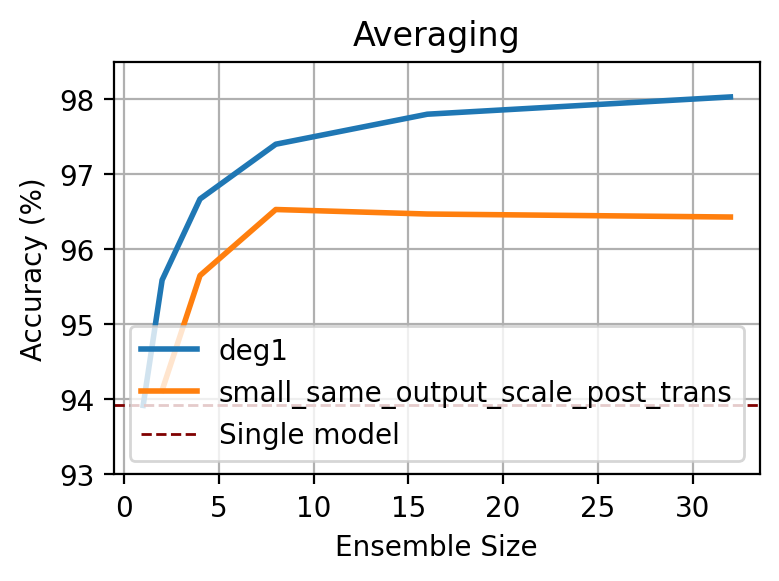

In [56]:
"""
Line plot of accuracy vs ensemble size
"""
# plot_df = df.loc[df["tag"].isin(["small", "medium", "large"])]
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="tag", 
    linewidth=2,
    # legend="auto",
)
plt.axhline(y=BEST_SINGLE_MODEL["accuracy"], linewidth=1, linestyle="--", color="maroon", label="Single model")
ax.grid()
ax.set_title("Averaging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
ax.legend(loc="lower center")
ax.set_ylim([93, 98.5])
# fig.legend(bbox_to_anchor=(0.5, -0.2), loc="lower center")
fig.tight_layout()
plt.savefig("averaging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("averaging_acc_v_ensemble_size_lineplot.png")

## Bagging

In [57]:
experiment_dir = "../bagging"
df = parse_seq_ensemble_exp(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
bagging_df = df
df

,trial,accuracy,loss,ensemble_size,tag
0,bagging_ensemble_size32,96.47,0.126,11,deg1
1,bagging_ensemble_size32,96.35,0.130,9,deg1
2,bagging_ensemble_size32,96.35,0.128,10,deg1
3,bagging_ensemble_size32,96.33,0.130,8,deg1
4,bagging_ensemble_size32,96.27,0.131,7,deg1
5,bagging_ensemble_size32,96.20,0.135,6,deg1
6,bagging_ensemble_size32,96.07,0.142,5,deg1
7,bagging_ensemble_size32,96.04,0.148,4,deg1
8,bagging_ensemble_size32,95.55,0.164,3,deg1
9,bagging_ensemble_size32,94.84,0.192,2,deg1


,trial,accuracy,loss,ensemble_size,tag
0,bagging_ensemble_size32,96.47,0.126,11,deg1
1,bagging_ensemble_size32,96.35,0.130,9,deg1
2,bagging_ensemble_size32,96.35,0.128,10,deg1
3,bagging_ensemble_size32,96.33,0.130,8,deg1
4,bagging_ensemble_size32,96.27,0.131,7,deg1
5,bagging_ensemble_size32,96.20,0.135,6,deg1
6,bagging_ensemble_size32,96.07,0.142,5,deg1
7,bagging_ensemble_size32,96.04,0.148,4,deg1
8,bagging_ensemble_size32,95.55,0.164,3,deg1
9,bagging_ensemble_size32,94.84,0.192,2,deg1


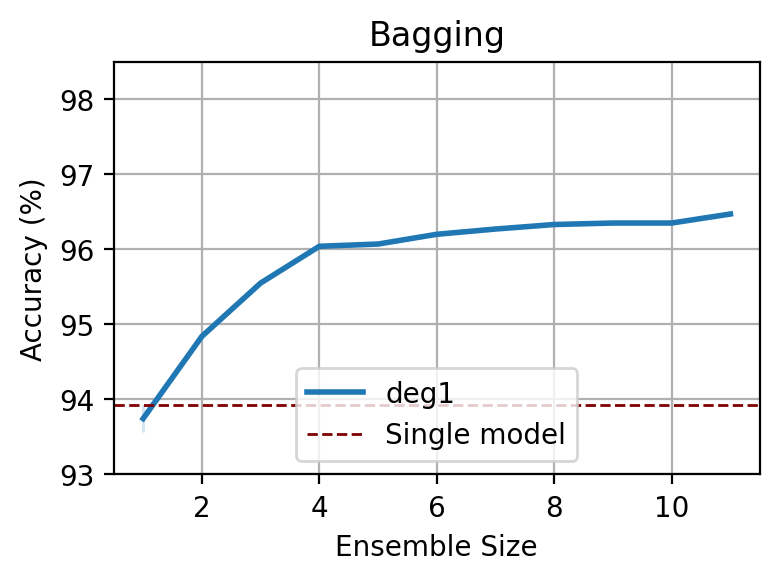

In [58]:
"""
Line plot of accuracy vs ensemble size
"""
# plot_df = df.loc[df["tag"].isin(["small", "medium", "large"])]
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="tag", 
    linewidth=2,
    # legend="auto",
)
plt.axhline(y=BEST_SINGLE_MODEL["accuracy"], linewidth=1, linestyle="--", color="maroon", label="Single model")
ax.grid()
ax.set_title("Bagging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
ax.legend(loc="lower center")
ax.set_ylim([93, 98.5])
# fig.legend(bbox_to_anchor=(0.5, -0.2), loc="lower center")
fig.tight_layout()
plt.savefig("bagging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("bagging_acc_v_ensemble_size_lineplot.png")

## AdaBoost

In [59]:
experiment_dir = "../adaboost"
df = parse_seq_ensemble_exp(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
adaboost_df = df
df

,trial,accuracy,loss,ensemble_size,tag
0,adaboost_ensemble_size32,95.30,1.616,11,deg1
1,adaboost_ensemble_size32,95.06,1.604,9,deg1
2,adaboost_ensemble_size32,94.98,1.599,8,deg1
3,adaboost_ensemble_size32,94.98,1.609,10,deg1
4,adaboost_ensemble_size32,94.40,1.595,7,deg1
5,adaboost_ensemble_size32,94.28,1.585,6,deg1
6,adaboost_ensemble_size32,94.15,1.523,4,deg1
7,best_single_model,93.92,0.193,1,deg1
8,adaboost_ensemble_size32,93.75,1.573,5,deg1
9,adaboost_ensemble_size32,93.51,1.449,1,deg1


,trial,accuracy,loss,ensemble_size,tag
0,adaboost_ensemble_size32,95.30,1.616,11,deg1
1,adaboost_ensemble_size32,95.06,1.604,9,deg1
2,adaboost_ensemble_size32,94.98,1.599,8,deg1
3,adaboost_ensemble_size32,94.98,1.609,10,deg1
4,adaboost_ensemble_size32,94.40,1.595,7,deg1
5,adaboost_ensemble_size32,94.28,1.585,6,deg1
6,adaboost_ensemble_size32,94.15,1.523,4,deg1
7,best_single_model,93.92,0.193,1,deg1
8,adaboost_ensemble_size32,93.75,1.573,5,deg1
9,adaboost_ensemble_size32,93.51,1.449,1,deg1


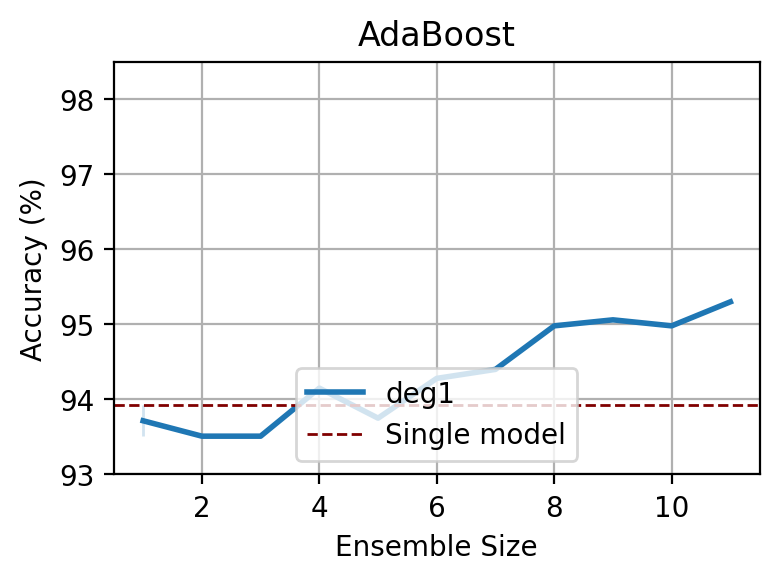

In [60]:
"""
Line plot of accuracy vs ensemble size
"""
# plot_df = df.loc[df["tag"].isin(["small", "medium", "large"])]
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="tag", 
    linewidth=2,
    # legend="auto",
)
plt.axhline(y=BEST_SINGLE_MODEL["accuracy"], linewidth=1, linestyle="--", color="maroon", label="Single model")
ax.grid()
ax.set_title("AdaBoost")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
ax.legend(loc="lower center")
ax.set_ylim([93, 98.5])

# fig.legend(bbox_to_anchor=(0.5, -0.2), loc="lower center")
fig.tight_layout()
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.png")

## Ensembling Comparison

In [61]:
averaging_df["ensemble_method"] = averaging_df["tag"].apply(lambda x: "Averaging")
bagging_df["ensemble_method"] = bagging_df["tag"].apply(lambda x: "Bagging")
adaboost_df["ensemble_method"] = adaboost_df["tag"].apply(lambda _: "AdaBoost")
all_df = pd.concat([averaging_df, bagging_df, adaboost_df])
all_df = add_single_model_data(all_df)
all_df

,trial,accuracy,loss,ensemble_size,tag,ensemble_method
0,averaging_ensemble_size32,98.03,0.102,32,deg1,Averaging
1,averaging_ensemble_size16,97.80,0.121,16,deg1,Averaging
2,averaging_ensemble_size8,97.40,0.112,8,deg1,Averaging
3,averaging_ensemble_size4,96.67,0.121,4,deg1,Averaging
4,deg1_same_output_scale_post_trans_ensemble_size8,96.53,0.141,8,small_same_output_scale_post_trans,Averaging
5,deg1_same_output_scale_post_trans_ensemble_size16,96.47,0.151,16,small_same_output_scale_post_trans,Averaging
6,deg1_same_output_scale_post_trans_ensemble_size32,96.43,0.167,32,small_same_output_scale_post_trans,Averaging
7,deg1_same_output_scale_post_trans_ensemble_size4,95.65,0.150,4,small_same_output_scale_post_trans,Averaging
8,averaging_ensemble_size2,95.59,0.151,2,deg1,Averaging
9,deg1_same_output_scale_post_trans_ensemble_size2,94.12,0.190,2,small_same_output_scale_post_trans,Averaging


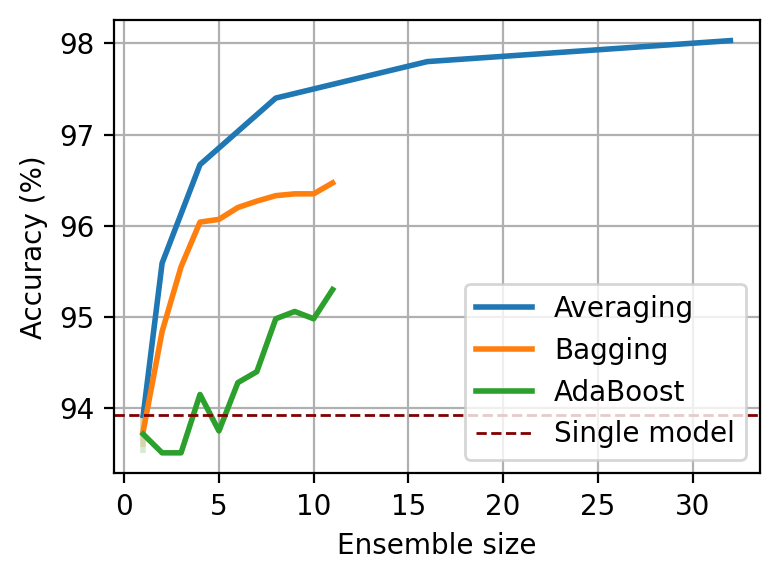

In [62]:
# Line plot for degree 1
plot_df = all_df[all_df["tag"] == "deg1"]
fig, ax = plt.subplots(figsize=(4, 3))

ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=BEST_SINGLE_MODEL["accuracy"], linewidth=1, linestyle="--", color="maroon", label="Single model")

ax.grid()
ax.legend(loc="lower right")

ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")

fig.tight_layout()